## Decomposition of moisture transport 

-  timeseries only within 3000 
-  spectral method? 
-  mean flow vs. eddies (timeseries and corr)
-  thermodynamic vs. dynamic (timeseries and corr)
-  compare with Tinghais data 

In [126]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import quiver 
import matplotlib.colors as colors
import cartopy.crs as ccrs
import atmotrans as atm 
from atmotrans import R,c

In [2]:
## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)

In [46]:
awt= 'tmpdir/monthly/awt_clim.nc'
awt = xr.open_dataset(awt)
awt_u= awt['p71.162'][0]
awt_v= awt['p72.162'][0]
q = np.abs(awt_u ) + np.abs(awt_v)


awt = 'tmpdir/monthly/awt_clim05.nc'
awt_may = xr.open_dataset(awt)
awt_u_may= awt_may['p71.162'][0]
awt_v_may= awt_may['p72.162'][0]
q_may = np.abs(awt_u_may) + np.abs(awt_v_may)
               
awt = 'tmpdir/monthly/awt_clim06.nc'
awt_jun = xr.open_dataset(awt)
awt_u_jun= awt_jun['p71.162'][0]
awt_v_jun= awt_jun['p72.162'][0]
q_jun = np.abs(awt_u_jun) + np.abs(awt_v_jun)

awt = 'tmpdir/monthly/awt_clim07.nc'
awt_jul = xr.open_dataset(awt)
awt_u_jul= awt_jul['p71.162'][0]
awt_v_jul= awt_jul['p72.162'][0]
q_jul = np.abs(awt_u_jul) + np.abs(awt_v_jul)

awt = 'tmpdir/monthly/awt_clim08.nc'
awt_aug = xr.open_dataset(awt)
awt_u_aug= awt_aug['p71.162'][0]
awt_v_aug= awt_aug['p72.162'][0]
q_aug = np.abs(awt_u_aug) + np.abs(awt_v_aug)

awt = 'tmpdir/monthly/awt_clim09.nc'
awt_sep = xr.open_dataset(awt)
awt_u_sep= awt_sep['p71.162'][0]
awt_v_sep= awt_sep['p72.162'][0]
q_sep = np.abs(awt_u_sep) + np.abs(awt_v_sep)


lons = awt_may['longitude']
lats = awt_may['latitude']

# convert coords to 2d array 
x,y = np.meshgrid(lons, lats)


## Monthly climatology 

In [55]:
def quick_plot(data):
    plt.figure(figsize=(15,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    m = plt.pcolormesh(lons,lats, data, transform= ccrs.PlateCarree())
    plt.colorbar()

In [52]:
def plot_awt(awt_u, awt_v, q):
    plt.figure(figsize=(16,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    m = plt.pcolormesh(lons, lats, q, transform= ccrs.PlateCarree(), cmap = 'plasma')
    ax.set_extent([50,130,10,50])
    ax.coastlines(linewidth = 1.5)
    plt.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')

    # Normalise the data for uniform arrow size
    u_norm = awt_u/ np.sqrt(awt_u ** 2.0 + awt_u ** 2.0)
    v_norm = awt_v / np.sqrt(awt_v ** 2.0 + awt_v ** 2.0)

    # Plot wind vectors 
    skip  =(slice(None,None,10),slice(None,None,10))
    ax.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color ='k', transform= ccrs.PlateCarree())

    cbar = plt.colorbar(m,extend= 'both',  label = 'water vapour flux kg m$^{-1}$ s$^{-1}$')
    plt.savefig('mean_awt.png')

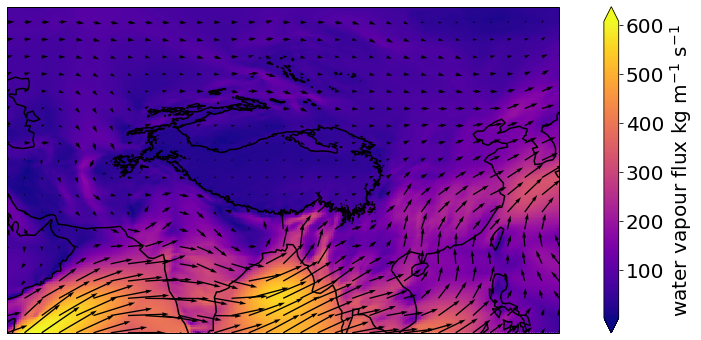

In [53]:
plot_awt(awt_u, awt_v, q)

## Climatology of water vapor transport 

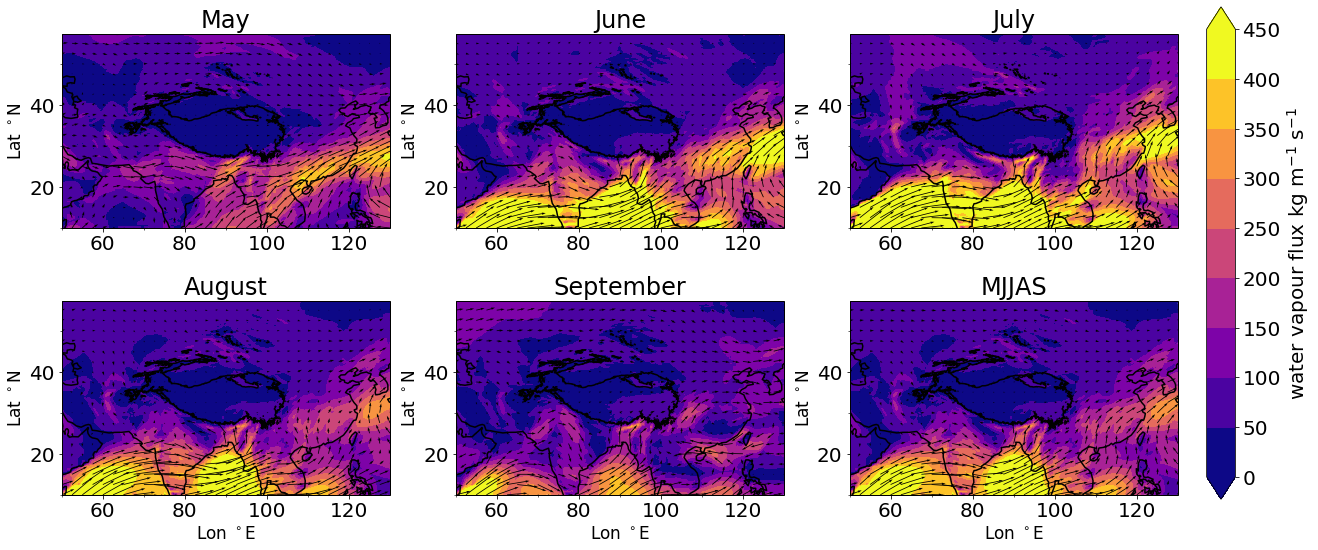

In [122]:
fig =plt.figure(figsize=(20,9))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
skip  =(slice(None,None,10),slice(None,None,10))
fs= 17
c= 'k'

# customizing of colorbar 
cmap=plt.cm.plasma
r = np.arange(0,500,50)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax1 = plt.subplot(2, 3, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('May')
ax1.coastlines(linewidth = 1.5)
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax1.pcolormesh(lons, lats, q_may,norm = norm, cmap = cmap  )    
ax1.quiver(x[skip],y[skip],awt_u_may[skip], awt_v_may[skip], color =c, transform= ccrs.PlateCarree()) 
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
    

ax2 = plt.subplot(2, 3, 2, projection=ccrs.PlateCarree())
ax2.set_extent([50,130,10,50])
ax2.set_title('June')
ax2.coastlines(linewidth = 1.5)
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax2.pcolormesh(lons, lats, q_jun,norm = norm, cmap = cmap  )
ax2.quiver(x[skip],y[skip],awt_u_jun[skip], awt_v_jun[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax2.set_xticks(xlabels, xlabels)
ax2.set_yticks(ylabels,ylabels)
ax2.set_ylabel('Lat $^\circ$N',  fontsize=fs)
     

ax3 = plt.subplot(2, 3, 3, projection=ccrs.PlateCarree())
ax3.set_extent([50,130,10,50])
ax3.set_title('July')
ax3.coastlines(linewidth = 1.5)
ax3.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax3.pcolormesh(lons, lats, q_jul,norm = norm, cmap = cmap  )
ax3.quiver(x[skip],y[skip],awt_u_jul[skip], awt_v_jul[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax3.set_xticks(xlabels, xlabels)
ax3.set_yticks(ylabels,ylabels)
ax3.set_ylabel('Lat $^\circ$N',  fontsize=fs)
   

ax4 = plt.subplot(2, 3, 4, projection=ccrs.PlateCarree())
ax4.set_extent([50,130,10,50])
ax4.set_title('August')
ax4.pcolormesh(lons, lats, q_aug,norm = norm, cmap = cmap  )
ax4.coastlines(linewidth = 1.5)
ax4.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax4.pcolormesh(lons, lats, q,norm = norm, cmap = cmap  )
ax4.quiver(x[skip],y[skip],awt_u_aug[skip], awt_v_aug[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax4.set_xticks(xlabels, xlabels)
ax4.set_yticks(ylabels,ylabels)
ax4.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax4.set_ylabel('Lat $^\circ$N',  fontsize=fs)
   
    
ax5 = plt.subplot(2, 3, 5, projection=ccrs.PlateCarree())
ax5.set_extent([50,130,10,50])
ax5.set_title('September')
ax5.coastlines(linewidth = 1.5)
ax5.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
ax5.pcolormesh(lons, lats, q_sep,norm = norm, cmap = cmap)
ax5.quiver(x[skip],y[skip],awt_u_sep[skip], awt_v_sep[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax5.set_xticks(xlabels, xlabels)
ax5.set_yticks(ylabels,ylabels)
ax5.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax5.set_ylabel('Lat $^\circ$N',  fontsize=fs)


ax6 = plt.subplot(2, 3, 6, projection=ccrs.PlateCarree())
ax6.set_extent([50,130,10,50])
ax6.set_title('MJJAS')
ax6.coastlines(linewidth = 1.5)
ax6.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
# Plot wind vectors 
m = ax6.pcolormesh(lons, lats, q,norm = norm, cmap = cmap)
ax6.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color =c, transform= ccrs.PlateCarree())
# axis labels 
ax6.set_xticks(xlabels, xlabels)
ax6.set_yticks(ylabels,ylabels)
ax6.set_xlabel('Lon $^\circ$E',  fontsize=fs)
ax6.set_ylabel('Lat $^\circ$N',  fontsize=fs)
      
    
cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m, cax=cb_ax1, extend = 'both', label = 'water vapour flux kg m$^{-1}$ s$^{-1}$')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/AWT_climatology.png')
plt.show()

## Calculate mean flow vs. eddies 

In [4]:
import glob
# surface pressures 
sp_files= glob.glob('tmpdir/monthly/*srfc_pressure*')
sp_files.sort()

# monthly primes
uprim_files = glob.glob('tmpdir/processed/qu*prim*nc')
vprim_files = glob.glob('tmpdir/processed/qv*prim*nc')
uprim_files.sort()
vprim_files.sort()

# monthly mean qV
monmean_files = glob.glob('tmpdir/monthly/test/*temperature-geopotential-specific_cloud_ice_water*nc') 
monmean_files.sort()

In [5]:
# preprocessing: get spacings 
lats= xr.open_dataset(monmean_files[0])['latitude'].values
lons= xr.open_dataset(monmean_files[0])['longitude'].values
dlat, dlon= atm.get_spacing(lats, lons)

# get pressure levels 
pressure =  xr.open_dataset(monmean_files[0])['level'].values

In [6]:
# initialize 
conv_mean = np.zeros((201,321))
conv_eddy = np.zeros((201,321))
conv_total = np.zeros((201,321)) 

for ymon in np.arange(20):
    print(ymon)
    # read in all mean fields 
    spdata= xr.open_dataset(sp_files[ymon])
    fields =xr.open_dataset(monmean_files[ymon])
    u = fields.u[0].values
    v = fields.v[0].values
    t = fields.t[0].values
    z = fields.z[0].values
    # specific humidity (water vapour in kg/kg)
    q = fields.q[0].values + fields.clwc[0].values + fields.clwc[0].values
    # surface pressure values 
    sp = spdata.sp[0].values /100
    fields.close()
    spdata.close()
############################## mean flow ############################

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0

    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d

    # get qV fields 
    qu = q*u
    qv = q*v 

    # colummn integration of q and wind fields 
    quint = atm.column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = atm.column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # divergence 
    udev = atm.dy_dlon(quint, dlon) 
    vdev = atm.dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    conv_mean += (udiv + vdiv)

    ################ transient eddy convergence ############################

    # read in file for one month 
    data= xr.open_dataset(uprim_files[ymon])
    qu_prime = data['__xarray_dataarray_variable__']
    data= xr.open_dataset(vprim_files[ymon])
    qv_prime= data['__xarray_dataarray_variable__']
    data.close()
    
    # save monthly mean deviation from mean 
    quvec = (qu + qu_prime)
    qvvec = (qv + qv_prime)

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1
            
        qu_prime[idx:36, ilat, ilon] = 0
        qv_prime[idx:36, ilat, ilon] = 0
        quvec[idx:36, ilat, ilon] = 0
        qvvec[idx:36, ilat, ilon] = 0        
        
    # column integration    
    qu_integrated = atm.column_integration(np.flip(quvec, axis= 0), np.flip(z, axis = 0), ax = 0)    
    qv_integrated = atm.column_integration(np.flip(qvvec, axis= 0), np.flip(z, axis = 0), ax = 0)    

    # divergence calculation 
    udev = atm.dy_dlon(qu_integrated, dlon) 
    vdev = atm.dy_dlat(qv_integrated, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])
    # sum derivatives along x and y axis to get divergence 
    conv_total += (udiv + vdiv)
    
   
    # colummn integration of q and wind fields 
    quint = atm.column_integration(np.flip(qu_prime, axis = 0), np.flip(z, axis = 0))
    qvint = atm.column_integration(np.flip(qv_prime, axis = 0), np.flip(z, axis = 0))

    # divergence 
    udev = atm.dy_dlon(quint, dlon) 
    vdev = atm.dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    conv_eddy += (udiv + vdiv)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Plot 

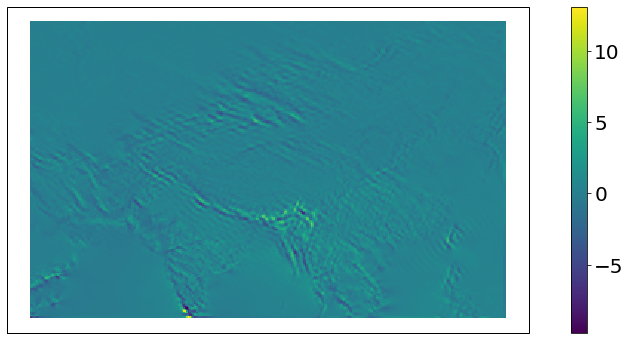

In [75]:
quick_plot(conv_mean/20* 86400* c)

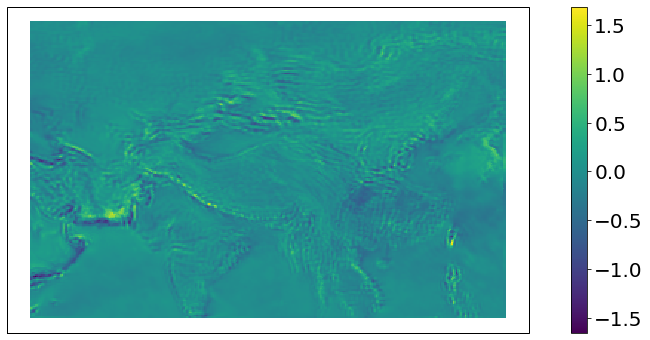

In [74]:
quick_plot(conv_eddy/20 * 86400* c)

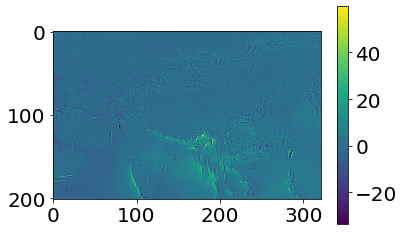

In [94]:
# for comparison 1: mean plot of vimd 
vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['p84.162'][0]
plt.imshow(-vimd*86400)
plt.colorbar()

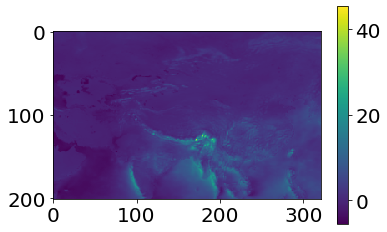

In [92]:
# for comparison 1: mean plot of vimd 
vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['vimd'][0]
plt.imshow(-vimd)
plt.colorbar()

## Divergence calculation - Spectral 

1. FFT F(f)
2. derivative of FFT (2*np.pi*i*f  * F(f))
3. add to calculate divergence
4. inverse FFT to convert back 

Questions: 
- how to calculate frequency 
- how to get i 
- what other step needs to be done when converting back from Fourier space into normal?

In [250]:
# for comparison 2: mean plot of divergence of verticaly integrated water flux
quint= xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['p71.162'][0]
qvint = xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['p72.162'][0]

In [262]:
# Fourier transformation
f_quint = np.fft.fft2(quint)
f_qvint = np.fft.fft2(qvint)

# first derivative 
f_quint_deriv = 2 * np.pi * i * f * f_quint 
f_qvint_deriv = 2 * np.pi * i * f * f_qvint 

# inverse fft 
quint = np.fft.ifft2(f_quint_deriv)
qvint = np.fft.ifft2(f_qvint_deriv)

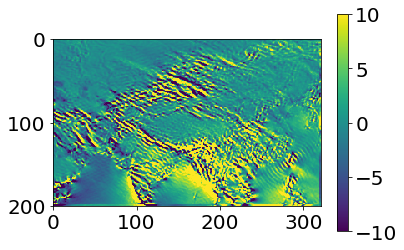

In [179]:

udev = atm.dy_dlon(quint, dlon) 
vdev = atm.dy_dlat(qvint, dlat) 
udiv = np.hstack([udev, np.zeros((201,2))])
vdiv = np.vstack([vdev, np.zeros((2,321))])
div = (udiv+vdiv)
plt.imshow(- div* 86400, vmin =-10, vmax = 10 )
plt.colorbar()

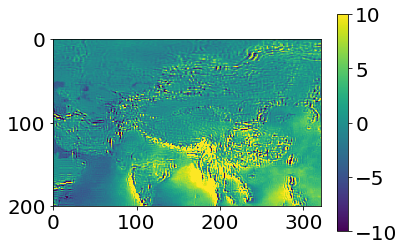

In [175]:
# for comparison 1: mean plot of vimd 
vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['p84.162'][0]
plt.imshow(-vimd*86400, vmin =-10, vmax = 10)
plt.colorbar()

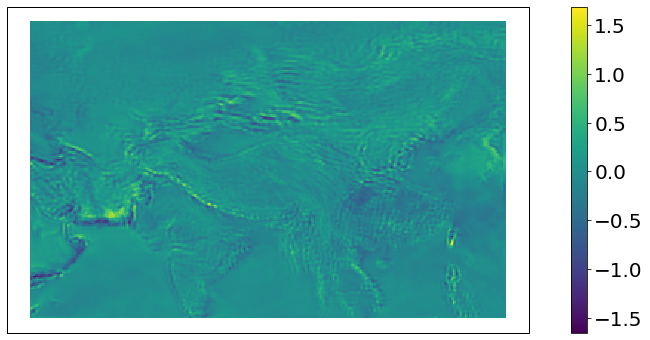

In [79]:
# eddy
quick_plot((conv_total/20* 86400*c - conv_mean/20 * 86400*c))

In [155]:
import wrf
smoothed = wrf.smooth2d(-(conv_mean/20) *86400, passes = 5)

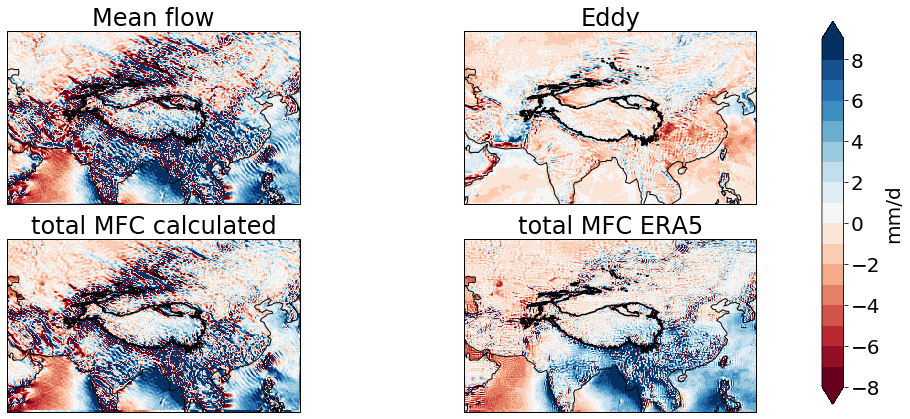

In [200]:
fig =plt.figure(figsize=(15,7))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
r = np.arange(-8,10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([50,130,10,50])
ax1.set_title('Mean flow')
m1= ax1.pcolormesh(lons, lats, -(conv_mean/20) *86400, cmap = cmap , norm = norm )
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines()   

ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_title('Eddy')
ax2.set_extent([50,130,10,50])
m= ax2.pcolormesh(lons, lats, -(conv_eddy/20) * 86400 , cmap = cmap , norm = norm )
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines()  

ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_title('total MFC calculated')
ax3.set_extent([50,130,10,50])
m= ax3.pcolormesh(lons, lats, -(div) * 86400, cmap = cmap , norm = norm )
ax3.contour(elevations.lon.values,elevations.lat.values,elevations.data.T, [3000], cmap = 'Greys_r')
ax3.coastlines()  
    
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_title('total MFC ERA5')
ax4.set_extent([50,130,10,50])
m= ax4.pcolormesh(lons, lats, -vimd * 86400 , cmap = cmap ,norm = norm )
ax4.contour(elevations.lon.values,elevations.lat.values,elevations.data.T, [3000], cmap = 'Greys_r')
ax4.coastlines()   
    
cb_ax1 = fig.add_axes([0.92, 0.14,0.02, 0.76])
cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both', label = 'mm/d')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/ERA5_decompose_mean_eddy.png')
plt.show()

In [ ]:
m=np.mean(conv_total, axis = 0 )
mean=np.mean(m, axis = 0 )

m=np.mean(conv_eddy, axis = 0 )
emean=np.mean(m, axis = 0 )

emean/mean * 100

## Thermodynamic vs. dynamic components 

In [219]:
# initialize 
thermodyn = np.zeros((201,321))
dynam = np.zeros((201,321))
qvdiv =  np.zeros((37, 201, 321))
wvdiv = np.zeros((37, 201, 321))
qudiv = np.zeros((37, 201, 321))
wudiv = np.zeros((37, 201, 321))

for ymon in np.arange(20):
    print(ymon)
    # read in all mean fields 
    spdata= xr.open_dataset(sp_files[ymon])
    fields =xr.open_dataset(monmean_files[ymon])
    u = fields.u[0].values
    v = fields.v[0].values
    t = fields.t[0].values
    z = fields.z[0].values
    # specific humidity (water vapour in kg/kg)
    q = fields.q[0].values + fields.clwc[0].values + fields.clwc[0].values
    # surface pressure values 
    sp = spdata.sp[0].values /100
    fields.close()
    spdata.close()
############################## mean flow ############################

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0
        u[idx:36, ilat, ilon] = 0
        v[idx:36, ilat, ilon] = 0

    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d

        # divergence for each level u 
        udev = atm.dy_dlon(q[plev], dlon) 
        vdev = atm.dy_dlat(q[plev], dlat) 
        qudiv[plev] = np.hstack([udev, np.zeros((201,2))])
        qvdiv[plev] = np.vstack([vdev, np.zeros((2,321))])

        # divergence for each level q
        udev = atm.dy_dlon(u[plev], dlon) 
        vdev = atm.dy_dlat(v[plev], dlat) 
        wudiv[plev] = np.hstack([udev, np.zeros((201,2))])
        wvdiv[plev] = np.vstack([vdev, np.zeros((2,321))])
    
    # product 
    qu_th = q * (qudiv + qvdiv)
    qu_dy = q * (wudiv + wvdiv)

    # colummn integration of thermodynamic 
    thermodyn += atm.column_integration(np.flip(qu_th, axis = 0), np.flip(z, axis = 0))
    dynam += atm.column_integration(np.flip(qu_dy, axis = 0), np.flip(z, axis = 0))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


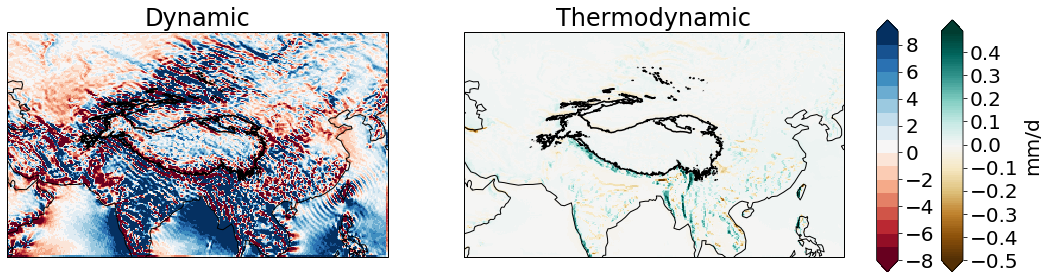

In [249]:
fig =plt.figure(figsize=(15,7))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]

fs= 25

# customizing of colorbar 
cmap=plt.cm.RdBu
cmap2=plt.cm.BrBG
r = np.arange(-8, 10)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
r = np.arange(-0.5,0.5,0.01)
norm2 = colors.BoundaryNorm(boundaries= r,  ncolors= 256)


ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_title('Dynamic')
ax1.set_extent([50,130,10,50])
m= ax1.pcolormesh(lons, lats, -(dynam/20) * 86400 , cmap = cmap , norm = norm )
ax1.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines()  

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([50,130,10,50])
ax2.set_title('Thermodynamic')
m2= ax2.pcolormesh(lons, lats, -(thermodyn/20) *86400, cmap = cmap2 , norm = norm2 )
ax2.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')
ax2.coastlines()   


cb_ax1 = fig.add_axes([0.93, 0.25,0.02, 0.5])
cb_ax2 = fig.add_axes([0.99, 0.25,0.02, 0.5])

cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both')
cbar = fig.colorbar(m2, cax=cb_ax2, extend = 'both', label = 'mm/d')
plt.rcParams.update({'font.size': 20})


plt.savefig('plots/ERA5_decompose_thermodyn_dyn.png')
plt.show()